Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

Loading Images

In [4]:
from tensorflow.keras.preprocessing.image import load_img 

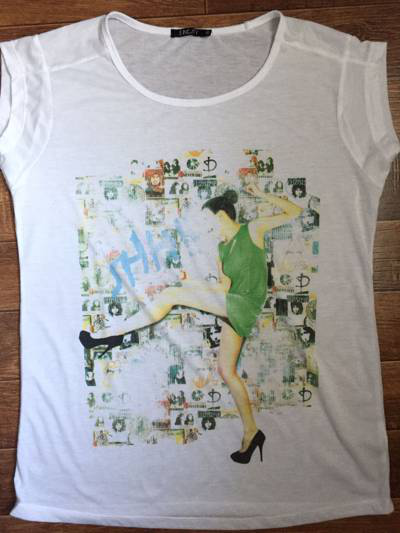

In [6]:
path = 'clothing-dataset-small/validation/t-shirt'
name = '09cd8fdf-bbe9-4908-8f54-f399bc635c9b.jpg'
fullname = path + '/' + name
load_img(fullname)

Resize the image for the network: 299 x 299

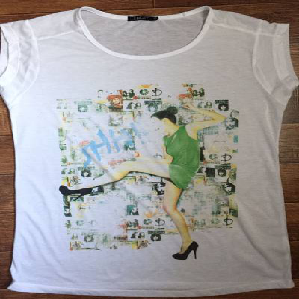

In [8]:
load_img(fullname, target_size=(299, 299))

For a 150 x 150 image

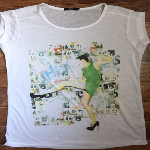

In [10]:
load_img(fullname, target_size=(150, 150))

Pre-Trained Neural Network
Apply a pre-trained neural network with imagenet classes.

We'll use Xception, but any other architecture will work as well.

We'll need to import 3 things:

the model itself (Xception)
the preprocess_input function that takes an image and prepares it
the decode_predictions that converts the predictions of the model into human-readable classes

In [12]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

Load the model. The pre-trained model expects 299x299 input

In [14]:
model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3)
)

Next,

   * we load the image using the load_img function
   * convert it to a numpy array
   * make it a batch of one example

In [16]:
img = load_img(fullname, target_size=(299, 299))
x = np.array(img)
x.shape

(299, 299, 3)

In [18]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

Next steps:

   * prepare the input
   * do the predictions
   * convert the predictions into a human-readable format


In [20]:
X = preprocess_input(X)

In [22]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [24]:
pred.shape

(1, 1000)

In [28]:
pred[0, :10]

array([5.3131171e-05, 8.7164735e-05, 8.2706109e-05, 4.1225456e-05,
       9.8696670e-05, 5.9375230e-05, 1.3445294e-04, 3.5964989e-05,
       5.2319770e-05, 7.3737123e-05], dtype=float32)

In [30]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n03595614', 'jersey', 0.8940531),
  ('n04370456', 'sweatshirt', 0.0038830503),
  ('n02834397', 'bib', 0.0035959794),
  ('n03877472', 'pajama', 0.0024887216),
  ('n03710637', 'maillot', 0.002071589)]]

### Transfer learning

Instead of loading each image one-by-one, we can use a data generator. Keras will use it for loading the images and pre-processing them


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Use smaller images as this will be faster

In [34]:
image_size = (150, 150)
batch_size = 32

Training data

In [36]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 952 images belonging to 10 classes.


Validation:

In [38]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 342 images belonging to 10 classes.


For fine-tuning, use Xception with small images (150x150)

In [40]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step


In [42]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

In [44]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [46]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.3876 - loss: 2.3664 - val_accuracy: 0.6433 - val_loss: 1.2826
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7901 - loss: 0.6721 - val_accuracy: 0.7310 - val_loss: 0.9780
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9162 - loss: 0.2477 - val_accuracy: 0.7339 - val_loss: 0.9431
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9573 - loss: 0.1492 - val_accuracy: 0.7222 - val_loss: 0.9796
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9936 - loss: 0.0638 - val_accuracy: 0.7398 - val_loss: 0.9589
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9932 - loss: 0.0494 - val_accuracy: 0.7135 - val_loss: 1.0709
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 0.7310 - val_loss: 1.0049
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.7398 - val_loss:

Graph for the accuracy of the Convolutional Neural Network, Xception, with a learning rate, lr = 0.01for 10 epochs:

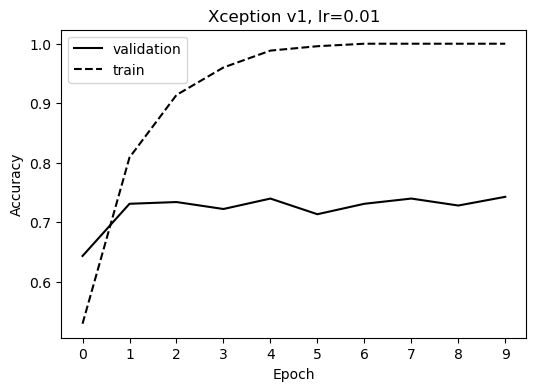

In [48]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('xception_v1_0_01.svg')

plt.show()

In [49]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [52]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3185 - loss: 1.9410 - val_accuracy: 0.6257 - val_loss: 1.1375
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7097 - loss: 0.9291 - val_accuracy: 0.6754 - val_loss: 0.9745
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7548 - loss: 0.7110 - val_accuracy: 0.6725 - val_loss: 0.9563
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8122 - loss: 0.5921 - val_accuracy: 0.7251 - val_loss: 0.8114
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8794 - loss: 0.4803 - val_accuracy: 0.7222 - val_loss: 0.8040
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9025 - loss: 0.4169 - val_accuracy: 0.7368 - val_loss: 0.7823
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9184 - loss: 0.3654 - val_accuracy: 0.7310 - val_loss: 0.7585
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9305 - loss: 0.3243 - val_accuracy: 0.7398 - val_loss:

Graph for the accuracy of the Convolutional Neural Network, Xception, with a learning rate, lr = 0.001for 10 epochs:

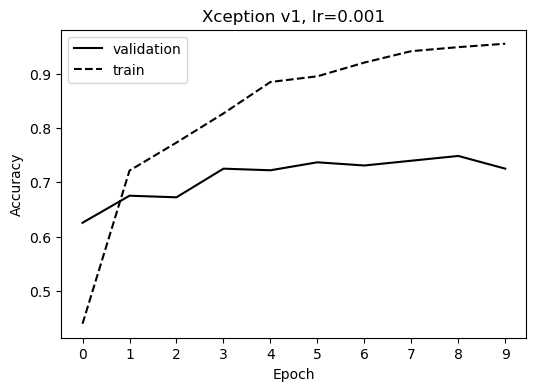

In [53]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

 learning rate of lr = 0.0001:

In [54]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1768 - loss: 2.3703 - val_accuracy: 0.1784 - val_loss: 2.2483
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3031 - loss: 2.0602 - val_accuracy: 0.2719 - val_loss: 1.9890
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3839 - loss: 1.8274 - val_accuracy: 0.3830 - val_loss: 1.7770
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4693 - loss: 1.6386 - val_accuracy: 0.4620 - val_loss: 1.6339
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5075 - loss: 1.5056 - val_accuracy: 0.5234 - val_loss: 1.4977
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5824 - loss: 1.3661 - val_accuracy: 0.5585 - val_loss: 1.4019
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6199 - loss: 1.2775 - val_accuracy: 0.5965 - val_loss: 1.3227
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6607 - loss: 1.1798 - val_accuracy: 0.6287 - val_loss:

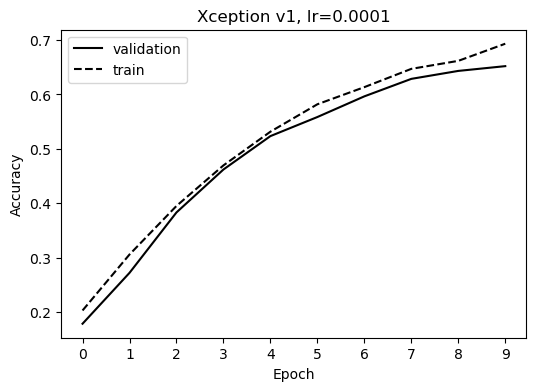

In [55]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [56]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

Plot for different learning rates:

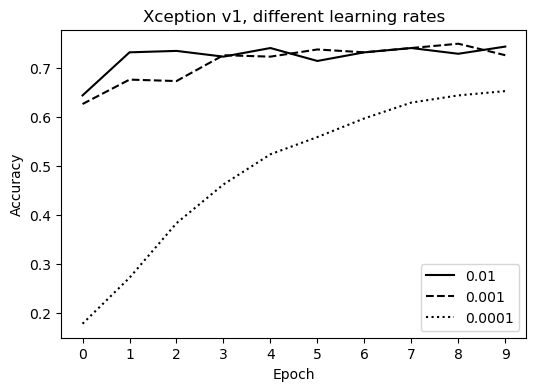

In [57]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

In [58]:
model = make_model(learning_rate=0.001)

In [59]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3099 - loss: 2.0474

30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3140 - loss: 2.0365 - val_accuracy: 0.5614 - val_loss: 1.2903
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6737 - loss: 0.9997

30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6749 - loss: 0.9966 - val_accuracy: 0.6725 - val_loss: 0.9527
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7715 - loss: 0.7073

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7719 - loss: 0.7068 - val_accuracy: 0.7251 - val_loss: 0.8331
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8615 - loss: 0.5470 - val_accuracy: 0.7222 - val_loss: 0.8209
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8764 - loss: 0.4726

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8762 - loss: 0.4727 - val_accuracy: 0.7427 - val_loss: 0.7788
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8931 - loss: 0.4352 - val_accuracy: 0.7427 - val_loss: 0.7743
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9228 - loss: 0.3742 - val_accuracy: 0.7398 - val_loss: 0.7801
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9426 - loss: 0.3032 - val_accuracy: 0.7398 - val_loss: 0.7729
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9408 - loss: 0.2813 - val_accuracy: 0.7398 - val_loss: 0.7603
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9638 - loss: 0.2402 - val_accuracy: 0.7339 - val_loss: 0.7496


In [60]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model    

In [61]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.3753 - loss: 1.8335

30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3792 - loss: 1.8218 - val_accuracy: 0.6901 - val_loss: 0.8880
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.7637 - loss: 0.6787

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7640 - loss: 0.6785 - val_accuracy: 0.7193 - val_loss: 0.8016
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.8796 - loss: 0.4261

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8797 - loss: 0.4261 - val_accuracy: 0.7222 - val_loss: 0.8294
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.9400 - loss: 0.2642

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9397 - loss: 0.2645 - val_accuracy: 0.7368 - val_loss: 0.7862
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9647 - loss: 0.1798

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9645 - loss: 0.1802 - val_accuracy: 0.7427 - val_loss: 0.7539
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9776 - loss: 0.1419 - val_accuracy: 0.7339 - val_loss: 0.7526
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9968 - loss: 0.0859

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9968 - loss: 0.0858 - val_accuracy: 0.7573 - val_loss: 0.8074
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9996 - loss: 0.0562 - val_accuracy: 0.7544 - val_loss: 0.7976
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0402 - val_accuracy: 0.7368 - val_loss: 0.8428
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0346 - val_accuracy: 0.7544 - val_loss: 0.8402
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.7427 - val_loss: 0.8350
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 0.7515 - val_loss: 0.8625
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.7515 - val_loss: 0.8755
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.7485 - val_loss: 0.869

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7632 - val_loss: 0.9500
Epoch 23/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.7515 - val_loss: 0.9483
Epoch 24/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.7632 - val_loss: 0.9517
Epoch 25/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7573 - val_loss: 0.9593
Epoch 26/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.7544 - val_loss: 0.9632
Epoch 27/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.7602 - val_loss: 0.9762
Epoch 28/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7573 - val_loss: 0.9860
Epoch 29/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.7427 - val_loss: 0.9

In [62]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.3583 - loss: 1.8884

30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3627 - loss: 1.8758 - val_accuracy: 0.6784 - val_loss: 1.0093
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.7217 - loss: 0.7894

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7221 - loss: 0.7882 - val_accuracy: 0.7047 - val_loss: 0.8470
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8380 - loss: 0.5166

30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8375 - loss: 0.5173 - val_accuracy: 0.7310 - val_loss: 0.7724
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8658 - loss: 0.3769 - val_accuracy: 0.7281 - val_loss: 0.7996
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9391 - loss: 0.2606

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9388 - loss: 0.2610 - val_accuracy: 0.7339 - val_loss: 0.8045
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9678 - loss: 0.1912 - val_accuracy: 0.7310 - val_loss: 0.7888
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9747 - loss: 0.1416 - val_accuracy: 0.7281 - val_loss: 0.8388
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9813 - loss: 0.1160 - val_accuracy: 0.7310 - val_loss: 0.8380
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.9882 - loss: 0.1042

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9882 - loss: 0.1041 - val_accuracy: 0.7544 - val_loss: 0.8163
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9913 - loss: 0.0776 - val_accuracy: 0.7339 - val_loss: 0.8471
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9822 - loss: 0.0795 - val_accuracy: 0.7456 - val_loss: 0.8156
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9979 - loss: 0.0421 - val_accuracy: 0.7485 - val_loss: 0.8675
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9985 - loss: 0.0461 - val_accuracy: 0.7310 - val_loss: 0.8974
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9941 - loss: 0.0447 - val_accuracy: 0.7456 - val_loss: 0.9050
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9972 - loss: 0.0362 - val_accuracy: 0.7515 - val_loss: 0.8932
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9985 - loss: 0.0303 - val_accuracy: 0.7427 - val_loss: 0.8

In [63]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.3095 - loss: 2.0114

30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3127 - loss: 2.0020 - val_accuracy: 0.6550 - val_loss: 1.1327
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.5906 - loss: 1.1450

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5913 - loss: 1.1440 - val_accuracy: 0.6871 - val_loss: 0.9862
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.7163 - loss: 0.8453

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7163 - loss: 0.8455 - val_accuracy: 0.7368 - val_loss: 0.8682
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7520 - loss: 0.7247

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7523 - loss: 0.7239 - val_accuracy: 0.7456 - val_loss: 0.7876
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7951 - loss: 0.5918 - val_accuracy: 0.7339 - val_loss: 0.8244
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8300 - loss: 0.4992

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8303 - loss: 0.4991 - val_accuracy: 0.7515 - val_loss: 0.7609
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8457 - loss: 0.4600 - val_accuracy: 0.7164 - val_loss: 0.8485
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8480 - loss: 0.4224 - val_accuracy: 0.7485 - val_loss: 0.7252
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9040 - loss: 0.3349 - val_accuracy: 0.7427 - val_loss: 0.7567
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8979 - loss: 0.3037 - val_accuracy: 0.7076 - val_loss: 0.8161
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9388 - loss: 0.2559 - val_accuracy: 0.7310 - val_loss: 0.7835
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9360 - loss: 0.2246 - val_accuracy: 0.7281 - val_loss: 0.7980
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9295 - loss: 0.2241 - val_accuracy: 0.7222 - val_loss: 0.8720

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9511 - loss: 0.1673 - val_accuracy: 0.7544 - val_loss: 0.8199
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9650 - loss: 0.1261 - val_accuracy: 0.7544 - val_loss: 0.8097
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9756 - loss: 0.1186 - val_accuracy: 0.7427 - val_loss: 0.8137
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9624 - loss: 0.1410 - val_accuracy: 0.7368 - val_loss: 0.8911
Epoch 20/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9698 - loss: 0.1166 - val_accuracy: 0.7193 - val_loss: 0.9109
Epoch 21/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9693 - loss: 0.1109 - val_accuracy: 0.7368 - val_loss: 0.8602
Epoch 22/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9765 - loss: 0.0992 - val_accuracy: 0.7456 - val_loss: 0.9329
Epoch 23/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9750 - loss: 0.0798

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9751 - loss: 0.0798 - val_accuracy: 0.7573 - val_loss: 0.8484
Epoch 24/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9771 - loss: 0.0868 - val_accuracy: 0.7368 - val_loss: 0.8704
Epoch 25/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9888 - loss: 0.0675 - val_accuracy: 0.7339 - val_loss: 0.9434
Epoch 26/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9726 - loss: 0.0762 - val_accuracy: 0.7339 - val_loss: 0.9826
Epoch 27/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9870 - loss: 0.0722 - val_accuracy: 0.7544 - val_loss: 0.8973
Epoch 28/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9873 - loss: 0.0599 - val_accuracy: 0.7398 - val_loss: 0.9839
Epoch 29/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9856 - loss: 0.0583 - val_accuracy: 0.7398 - val_loss: 0.9140
Epoch 30/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9873 - loss: 0.0516

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9873 - loss: 0.0516 - val_accuracy: 0.7602 - val_loss: 1.0024


In [64]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2111 - loss: 2.5617

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2133 - loss: 2.5504 - val_accuracy: 0.3860 - val_loss: 1.6971
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4026 - loss: 1.7722

30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4022 - loss: 1.7717 - val_accuracy: 0.5585 - val_loss: 1.4447
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3950 - loss: 1.6794

30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3953 - loss: 1.6790 - val_accuracy: 0.6199 - val_loss: 1.3369
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4817 - loss: 1.5672 - val_accuracy: 0.5877 - val_loss: 1.2556
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.4736 - loss: 1.4596

30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4740 - loss: 1.4584 - val_accuracy: 0.6959 - val_loss: 1.0983
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5483 - loss: 1.3079 - val_accuracy: 0.6579 - val_loss: 1.1092
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5241 - loss: 1.2831

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5243 - loss: 1.2833 - val_accuracy: 0.7047 - val_loss: 0.9778
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5379 - loss: 1.2433 - val_accuracy: 0.6784 - val_loss: 1.0144
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5670 - loss: 1.1934 - val_accuracy: 0.6637 - val_loss: 0.9960
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5552 - loss: 1.1839 - val_accuracy: 0.6901 - val_loss: 0.9312
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5636 - loss: 1.1279 - val_accuracy: 0.7047 - val_loss: 0.9244
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5540 - loss: 1.1320

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5551 - loss: 1.1309 - val_accuracy: 0.7135 - val_loss: 0.8754
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6168 - loss: 1.0737

30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6164 - loss: 1.0743 - val_accuracy: 0.7193 - val_loss: 0.8620
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6418 - loss: 0.9670 - val_accuracy: 0.7135 - val_loss: 0.8619
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6235 - loss: 1.0350 - val_accuracy: 0.7105 - val_loss: 0.8631
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.6382 - loss: 1.0064

30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6386 - loss: 1.0047 - val_accuracy: 0.7251 - val_loss: 0.8082
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.6679 - loss: 0.8815

30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6674 - loss: 0.8833 - val_accuracy: 0.7368 - val_loss: 0.8103
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6183 - loss: 0.9418 - val_accuracy: 0.7193 - val_loss: 0.8319
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6936 - loss: 0.8528

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6929 - loss: 0.8534 - val_accuracy: 0.7456 - val_loss: 0.7745
Epoch 20/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6475 - loss: 0.8977 - val_accuracy: 0.7135 - val_loss: 0.8480
Epoch 21/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6812 - loss: 0.8613 - val_accuracy: 0.7339 - val_loss: 0.7986
Epoch 22/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6850 - loss: 0.8120 - val_accuracy: 0.7222 - val_loss: 0.8208
Epoch 23/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7027 - loss: 0.7915 - val_accuracy: 0.7339 - val_loss: 0.7927
Epoch 24/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6996 - loss: 0.8076

30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6990 - loss: 0.8083 - val_accuracy: 0.7515 - val_loss: 0.7641
Epoch 25/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6697 - loss: 0.9080 - val_accuracy: 0.7222 - val_loss: 0.8208
Epoch 26/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7186 - loss: 0.7501 - val_accuracy: 0.7368 - val_loss: 0.7831
Epoch 27/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7155 - loss: 0.7362 - val_accuracy: 0.7368 - val_loss: 0.7979
Epoch 28/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7253 - loss: 0.7194 - val_accuracy: 0.7251 - val_loss: 0.8041
Epoch 29/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7121 - loss: 0.7188 - val_accuracy: 0.7310 - val_loss: 0.8321
Epoch 30/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7373 - loss: 0.6947 - val_accuracy: 0.7251 - val_loss: 0.7944


In [65]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

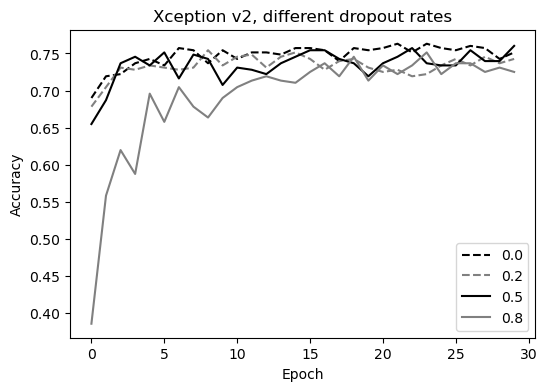

In [66]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

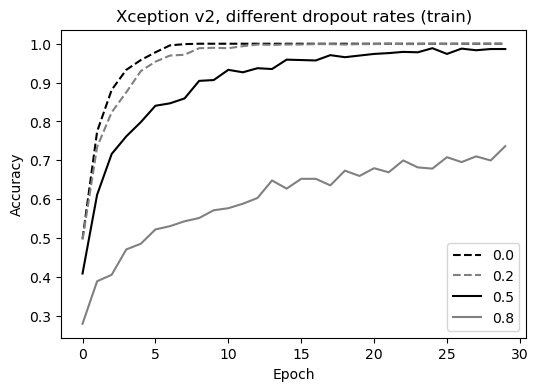

In [67]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

## Data augmentation

In [68]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 342 images belonging to 10 classes.


In [69]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 952 images belonging to 10 classes.


In [70]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3143 - loss: 1.9057

30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3183 - loss: 1.8954 - val_accuracy: 0.6520 - val_loss: 1.0272
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.6803 - loss: 0.9385

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6807 - loss: 0.9378 - val_accuracy: 0.7164 - val_loss: 0.8399
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7586 - loss: 0.7125 - val_accuracy: 0.7018 - val_loss: 0.8818
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8008 - loss: 0.5709 - val_accuracy: 0.6930 - val_loss: 0.8788
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7776 - loss: 0.5914 - val_accuracy: 0.7135 - val_loss: 0.8456
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8525 - loss: 0.4518 - val_accuracy: 0.7076 - val_loss: 0.8335
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8905 - loss: 0.3547

30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8902 - loss: 0.3554 - val_accuracy: 0.7456 - val_loss: 0.7805
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9057 - loss: 0.2907 - val_accuracy: 0.7368 - val_loss: 0.8007
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9396 - loss: 0.2525 - val_accuracy: 0.7339 - val_loss: 0.7816
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9166 - loss: 0.2719 - val_accuracy: 0.7398 - val_loss: 0.7848
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9366 - loss: 0.2165 - val_accuracy: 0.7281 - val_loss: 0.8831
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.9301 - loss: 0.2301

30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9303 - loss: 0.2302 - val_accuracy: 0.7573 - val_loss: 0.7810
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9594 - loss: 0.1652 - val_accuracy: 0.7251 - val_loss: 0.8711
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9510 - loss: 0.1725 - val_accuracy: 0.6988 - val_loss: 0.9380
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9426 - loss: 0.1729 - val_accuracy: 0.6988 - val_loss: 0.9153
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9597 - loss: 0.1559 - val_accuracy: 0.7368 - val_loss: 0.8979
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9607 - loss: 0.1415 - val_accuracy: 0.7251 - val_loss: 0.8477
Epoch 18/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9595 - loss: 0.1200 - val_accuracy: 0.7281 - val_loss: 0.8986
Epoch 19/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9553 - loss: 0.1399 - val_accuracy: 0.7339 - val_loss: 0.8

30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9883 - loss: 0.0430 - val_accuracy: 0.7632 - val_loss: 0.9237
Epoch 42/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9857 - loss: 0.0503 - val_accuracy: 0.7515 - val_loss: 0.9695
Epoch 43/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9846 - loss: 0.0609 - val_accuracy: 0.7222 - val_loss: 1.1498
Epoch 44/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9886 - loss: 0.0505 - val_accuracy: 0.7281 - val_loss: 1.0705
Epoch 45/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9753 - loss: 0.0689 - val_accuracy: 0.7456 - val_loss: 0.9835
Epoch 46/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9908 - loss: 0.0552 - val_accuracy: 0.7544 - val_loss: 0.9975
Epoch 47/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9869 - loss: 0.0403 - val_accuracy: 0.7515 - val_loss: 0.9921
Epoch 48/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9880 - loss: 0.0545 - val_accuracy: 0.7427 - val_loss: 1.0

In [71]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

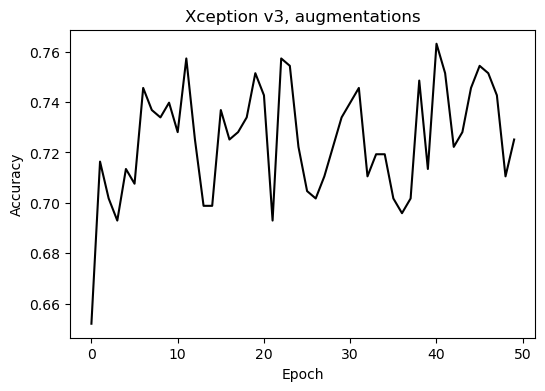

In [72]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

## Larger model

In [73]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [74]:
image_size = (299, 299)
batch_size = 32

In [75]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 342 images belonging to 10 classes.


In [87]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy

# Redefine generators with correct image size
image_size = (299, 299)
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True
)

validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds_fixed = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size
)

val_ds_fixed = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size
)

# Recreate model with correct loss
model = make_model(learning_rate=0.001, droprate=0.2)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_large_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

# Train with fixed dataset
history_l = model.fit(train_ds_fixed, epochs=20, validation_data=val_ds_fixed, callbacks=callbacks)


Found 952 images belonging to 10 classes.
Found 342 images belonging to 10 classes.
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4124 - loss: 1.6965

30/30 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.4172 - loss: 1.6843 - val_accuracy: 0.7398 - val_loss: 0.8130
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7632 - loss: 0.7157

30/30 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.7632 - loss: 0.7145 - val_accuracy: 0.7924 - val_loss: 0.6175
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8144 - loss: 0.5729

30/30 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.8146 - loss: 0.5716 - val_accuracy: 0.8099 - val_loss: 0.5231
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8471 - loss: 0.4427

30/30 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.8469 - loss: 0.4431 - val_accuracy: 0.8187 - val_loss: 0.5369
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8574 - loss: 0.3970

30/30 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.8577 - loss: 0.3969 - val_accuracy: 0.8275 - val_loss: 0.5373
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.8872 - loss: 0.3407 - val_accuracy: 0.8187 - val_loss: 0.5165
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9258 - loss: 0.2566

30/30 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9250 - loss: 0.2582 - val_accuracy: 0.8596 - val_loss: 0.4401
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9113 - loss: 0.2585 - val_accuracy: 0.8567 - val_loss: 0.4282
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9361 - loss: 0.2322 - val_accuracy: 0.8333 - val_loss: 0.4782
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.9346 - loss: 0.2070 - val_accuracy: 0.8333 - val_loss: 0.5042
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9387 - loss: 0.1928 - val_accuracy: 0.8304 - val_loss: 0.4904
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.9482 - loss: 0.1694 - val_accuracy: 0.8304 - val_loss: 0.5079
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9515 - loss: 0.1606 - val_accuracy: 0.8392 - val_loss: 0.4637
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.9477 - loss: 0.1681 - val_accuracy: 0.8596 - val_los